In [97]:
# imports
import torch
from torch import nn
from torch.nn import functional as F

import math
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time

import pickle as pkl

In [52]:
# set seed
_ = torch.manual_seed(13)

In [53]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [46]:
transform = transforms.ToTensor()

train_set = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, num_workers=0
)

## Visualize the data

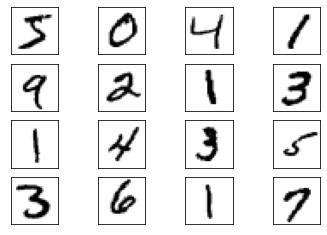

In [55]:
real_samples, mnist = next(iter(train_loader))
for (index, image) in enumerate(real_samples[0:16]):
    ax = plt.subplot(4, 4, index + 1)
    plt.imshow(image.reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Models

In [16]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)

        return out


class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

## Hyper Params

In [20]:
input_size = 784
d_output_size = 1
d_hidden_size = 32

z_size = 100
g_output_size = 784
g_hidden_size = 32

In [25]:
D = Discriminator(input_size, d_hidden_size, d_output_size).to(device=device)
G = Generator(z_size, g_hidden_size, g_output_size).to(device=device)

## Losses

In [27]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [29]:
lr = 0.002

d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

## Training

In [69]:
num_epochs = 100

samples = []
losses = []

print_every = 400

sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

In [71]:
D.train()
G.train()
for epoch in range(num_epochs):
    
    epoch_start_time = time.time()

    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
            
    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
    
    # print time
    print(f"Time for epoch: {time.time() - epoch_start_time}")


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.1589 | g_loss: 1.6480
Epoch [    1/  100] | d_loss: 1.0476 | g_loss: 1.2775
Epoch [    1/  100] | d_loss: 1.4148 | g_loss: 0.7242
Time for epoch: 8.332435607910156
Epoch [    2/  100] | d_loss: 0.9486 | g_loss: 2.7714
Epoch [    2/  100] | d_loss: 1.1148 | g_loss: 2.6797
Epoch [    2/  100] | d_loss: 1.1259 | g_loss: 1.0415
Time for epoch: 8.47434115409851
Epoch [    3/  100] | d_loss: 1.2681 | g_loss: 1.4005
Epoch [    3/  100] | d_loss: 1.1867 | g_loss: 1.1374
Epoch [    3/  100] | d_loss: 1.0616 | g_loss: 1.8502
Time for epoch: 9.01014256477356
Epoch [    4/  100] | d_loss: 1.5032 | g_loss: 1.0980
Epoch [    4/  100] | d_loss: 1.0379 | g_loss: 1.4901
Epoch [    4/  100] | d_loss: 1.2116 | g_loss: 1.4251
Time for epoch: 8.49666142463684
Epoch [    5/  100] | d_loss: 1.2319 | g_loss: 0.9634
Epoch [    5/  100] | d_loss: 1.1678 | g_loss: 1.0042
Epoch [    5/  100] | d_loss: 1.1001 | g_loss: 2.0583
Time for epoch: 9.119372606277466
Epoch [    6/  100] | d

Time for epoch: 9.589284181594849
Epoch [   43/  100] | d_loss: 1.2643 | g_loss: 1.0824
Epoch [   43/  100] | d_loss: 1.2991 | g_loss: 0.9042
Epoch [   43/  100] | d_loss: 1.3810 | g_loss: 1.0554
Time for epoch: 8.975579977035522
Epoch [   44/  100] | d_loss: 1.2251 | g_loss: 1.0440
Epoch [   44/  100] | d_loss: 1.3150 | g_loss: 1.0092
Epoch [   44/  100] | d_loss: 1.3393 | g_loss: 1.1833
Time for epoch: 9.863157987594604
Epoch [   45/  100] | d_loss: 1.2773 | g_loss: 0.8579
Epoch [   45/  100] | d_loss: 1.2907 | g_loss: 0.9378
Epoch [   45/  100] | d_loss: 1.2726 | g_loss: 1.2122
Time for epoch: 11.243767023086548
Epoch [   46/  100] | d_loss: 1.3595 | g_loss: 0.8528
Epoch [   46/  100] | d_loss: 1.2456 | g_loss: 1.1401
Epoch [   46/  100] | d_loss: 1.2917 | g_loss: 1.3628
Time for epoch: 9.859166383743286
Epoch [   47/  100] | d_loss: 1.3388 | g_loss: 0.9367
Epoch [   47/  100] | d_loss: 1.3268 | g_loss: 0.9095
Epoch [   47/  100] | d_loss: 1.3035 | g_loss: 1.0578
Time for epoch: 10.

Time for epoch: 10.205925464630127
Epoch [   85/  100] | d_loss: 1.2877 | g_loss: 0.9281
Epoch [   85/  100] | d_loss: 1.2642 | g_loss: 0.9059
Epoch [   85/  100] | d_loss: 1.3773 | g_loss: 1.1183
Time for epoch: 9.751403331756592
Epoch [   86/  100] | d_loss: 1.2728 | g_loss: 0.9723
Epoch [   86/  100] | d_loss: 1.1997 | g_loss: 1.2036
Epoch [   86/  100] | d_loss: 1.2957 | g_loss: 1.1768
Time for epoch: 10.404082775115967
Epoch [   87/  100] | d_loss: 1.2478 | g_loss: 1.1217
Epoch [   87/  100] | d_loss: 1.2376 | g_loss: 0.9636
Epoch [   87/  100] | d_loss: 1.2084 | g_loss: 1.2775
Time for epoch: 9.584916591644287
Epoch [   88/  100] | d_loss: 1.3008 | g_loss: 0.9757
Epoch [   88/  100] | d_loss: 1.3131 | g_loss: 1.0176
Epoch [   88/  100] | d_loss: 1.3062 | g_loss: 1.2773
Time for epoch: 8.935511589050293
Epoch [   89/  100] | d_loss: 1.1385 | g_loss: 1.1590
Epoch [   89/  100] | d_loss: 1.2950 | g_loss: 0.9139
Epoch [   89/  100] | d_loss: 1.4483 | g_loss: 1.0292
Time for epoch: 10

## Save the params

In [73]:
torch.save(G.state_dict(), "model/new_arch")

## Plot Training Loss

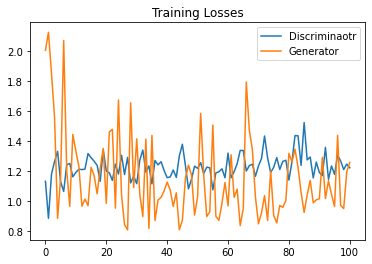

In [76]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminaotr")
plt.plot(losses.T[1], label="Generator")
plt.title("Training Losses")
plt.legend()

In [77]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [87]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

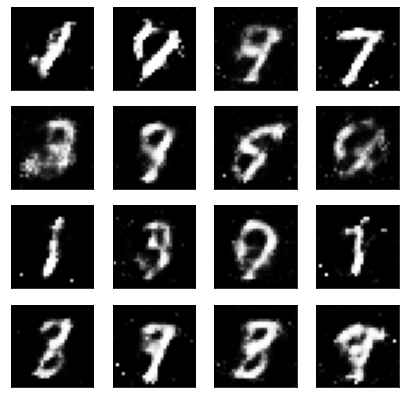

In [88]:
view_samples(-1, samples)

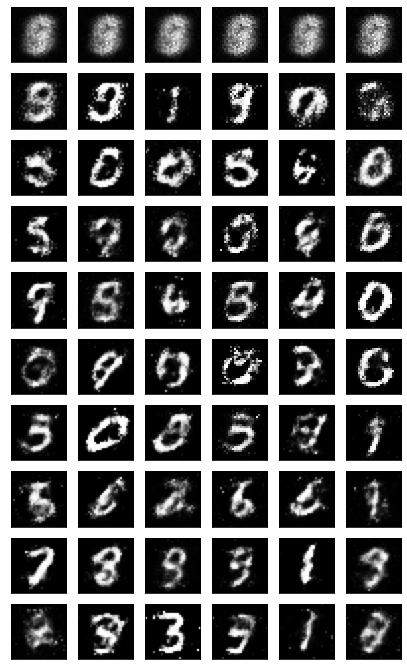

In [89]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


In [90]:
## New randomly generated

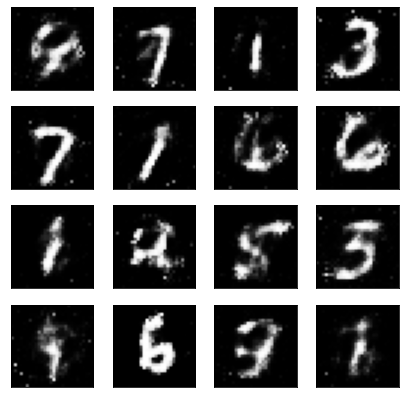

In [95]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])